In [1]:
# python libraries
from typing import List,Dict
import time
import sys


sys.path.append("c:\\Users\\Lenovo\\DataspellProjects\\PyTorch2")

# helper module
import helper

# torch
import torch
import torchvision
from torch import nn
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from torchmetrics import Accuracy

# data manipulation
import numpy as np

#visualization
import matplotlib.pyplot as plt

%matplotlib widget

# FashionMNIST

## Loading the dataset

In [2]:
class FashionMNIST(helper.DataModule):
    def __init__(self, batch_size=64, resize=(28, 28)) -> None:
        super().__init__()
        self.batch_size = batch_size
        self.resize = resize

        transform = transforms.Compose(
            [transforms.Resize(resize), transforms.ToTensor()]
        )

        self.train = datasets.FashionMNIST(
            root=self.root, train=True, transform=transform, download=True
        )
        self.val = datasets.FashionMNIST(
            root=self.root, train=False, transform=transform, download=True
        )
        self.classes = self.train.classes
        self.class_to_idx = self.train.class_to_idx

    def text_labels(self, indices: List):
        return [self.classes[int(i)] for i in indices]

    def get_dataloader(self, train: bool):
        data = self.train if train else self.val
        return DataLoader(
            dataset=data,
            batch_size=self.batch_size,
            shuffle=train,
            num_workers=self.num_workers,
        )

    def visualize(self, batch, num_rows=1, num_cols=8):
        X, y = batch
        labels = self.text_labels(y)
        helper.show_images(
            X.squeeze(dim=1), num_rows=num_rows, num_cols=num_cols, titles=labels
        )


In [3]:
data  = FashionMNIST(resize=(32,32))

In [4]:
# start = time.time()
# for X,y in data.train_dataloader():
#     continue
# f"{time.time() - start:.2f} secs"

#? Built in data loader itself take long time to load.

In [5]:
X,y = next(iter(data.train_dataloader()))
X.shape,X[0].shape, y.shape

(torch.Size([64, 1, 32, 32]), torch.Size([1, 32, 32]), torch.Size([64]))

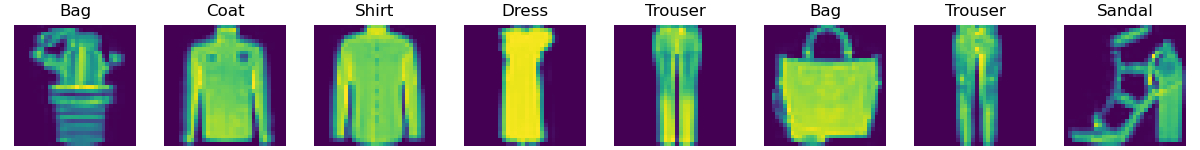

In [6]:
batch = next(iter(data.train_dataloader()))
data.visualize(batch=batch)


# Base Classifier

In [7]:
class Classifier(helper.Module):
    def accuracy(self,y_logits, y):
        acc_fn = Accuracy(task="multiclass",num_classes=self.num_outputs)
        return acc_fn(y_logits, y)

    def step(self, batch: List)->Dict:
        X, y = batch
        # forward pass
        y_logits = self(X).squeeze(1)
        loss = self.loss(y_logits, y)
        acc = self.accuracy(y_logits, y)
        return dict(loss=loss,acc=acc)

    def validation_step(self, batch: List):
        return self.step(batch)

    def training_step(self, batch: List):
        return self.step(batch)

    def loss(self, y_logits, y):
        loss_fn = nn.CrossEntropyLoss()
        return loss_fn(y_logits, y)


# Classifier

In [8]:
class SoftmaxRegression(Classifier):
    def __init__(self,num_outputs,lr) -> None:
        super().__init__()
        self.num_outputs = num_outputs
        self.lr = lr
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(self.num_outputs)
        )
    
    def forward(self,x):
        return self.net(x)



# Training process

c:\Users\Lenovo\anaconda3\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/3 [00:00<?, ?it/s]

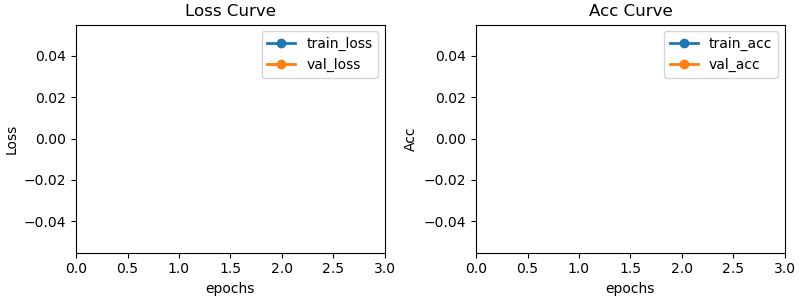

In [9]:
data = FashionMNIST(batch_size=256)
model = SoftmaxRegression(num_outputs=10,lr=0.1)
trainer = helper.Trainer(max_epochs=3,show_ani=True,verbose=False)
trainer.fit(model,data)